In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import os
import nibabel
import glob
import shutil

%matplotlib inline


import cv2

import xml.etree.ElementTree as ET
from scipy.spatial.distance import euclidean

In [7]:
BASE_DIR = "/media/df3-dafna/Netanell/BLLAMODEL/"
BASE_DIR_WIN = r"file:\\fmri-df3\dafna\Netanell\BLLAMODEL\{}"
FD_RE = re.compile("Pat(?P<patient_id>[\d]+)_Se(?P<series>[\d]+)_Res(?P<res_x>[\d.]+)_(?P<res_y>[\d.]+)_Spac(?P<res_z>[\d]+)_data.nii.gz")


In [2]:
def parse_annotation(annot_file):
    tree = ET.parse(annot_file)
    root = tree.getroot()
    
    xy_res = float(annot_file.split("Res")[1].split("_")[0])
    
    measures = {}
    points = {}

    for elem in root.findall('folder'):
        if elem.attrib['key'] == 'Annotations':
            root = elem
    for elem in root.findall('folder'):
        pts = []
        color = ""
        for entry in elem.findall('entry'):
            if entry.attrib['key'] in ['Point1', 'Point2']:
                pts.append([float(a) for a in entry.attrib['value'].split(" ")])
            elif entry.attrib['key'] in ['Color',]:
                color = entry.attrib['value']
        pts_arr = np.array(pts)
        meas_len = euclidean(pts_arr[0], pts_arr[1])*xy_res
        #print(color, meas_len)
        if color == "1 0 0":
            measures['TCD'] = meas_len
            points['TCD'] = pts_arr
        else:
            if 'CBD' in measures.keys():
                if measures['CBD'] > meas_len:
                    measures['BBD'] = measures['CBD']
                    measures['CBD'] = meas_len
                    
                    points['BBD'] = points['CBD']
                    points['CBD'] = pts_arr
                else:
                    measures['BBD'] = meas_len
                    
                    points['BBD'] = pts_arr
            else:
                measures['CBD'] = meas_len 
                
                points['CBD'] = pts_arr
    return measures, points

In [3]:
def parse_dir(dir_name):
    ANNOT_RE = re.compile("Pat(?P<patient_id>[\d]+)_Se(?P<series>[\d]+)_Res(?P<res_x>[\d.]+)_(?P<res_y>[\d.]+)_Spac(?P<res_z>[\d]+).annot") 
    measures_list = []
    for annot in glob.glob(os.path.join(dir_name, "*.annot")):
        annot_metadata = re.match(ANNOT_RE, os.path.basename(annot))
        measures, points = parse_annotation(annot)
        measures['Subject'] = int(annot_metadata['patient_id'])
        measures['Series'] =  int(annot_metadata['series'])
        measures['resX'] =  float(annot_metadata['res_x'])
        measures['resY'] =  float(annot_metadata['res_y'])
        measures['resZ'] =  float(annot_metadata['res_z'])
        if 'TCD' in points.keys():
            measures['TCD_Selection'] = int(points['TCD'][0,2] + .5)
            measures['Measure_TCD_X1'] = int(points['TCD'][0,0] + .5)
            measures['Measure_TCD_Y1'] = int(points['TCD'][0,1] + .5)
            measures['Measure_TCD_X2'] = int(points['TCD'][1,0] + .5)
            measures['Measure_TCD_Y2'] = int(points['TCD'][1,1] + .5)
        else:
            measures['TCD_Selection'] = None
        if 'BBD' in points.keys():
            measures['BBD_Selection'] = int(points['BBD'][0,2] + .5)
        else:
            measures['BBD_Selection'] = None
        measures_list.append(measures)
        print (measures)
    df2 = pd.DataFrame(measures_list, columns=['Subject', 'Series', 'resX', 'resY', 'resZ', 'TCD', 'CBD', 'BBD', 'TCD_Selection', 'BBD_Selection', 'Measure_TCD_X1', 'Measure_TCD_Y1', 'Measure_TCD_X2', 'Measure_TCD_Y2'])
    return df2

In [184]:
NETANELL_ANNOT_DIR = "/media/df3-dafna/Netanell/TCD_ToAnnotate/InputNetanell/"
LIAT_ANNOT_DIR = "/media/df3-dafna/Netanell/TCD_ToAnnotate/Annotations/Liat/"

In [185]:
dd1 = parse_dir(NETANELL_ANNOT_DIR)
dd2 = parse_dir(LIAT_ANNOT_DIR)
dd1['Anottator'] = 'Netanell'
dd2['Anottator'] = 'Liat'
dd_f = pd.concat([dd1,dd2]).reset_index()

{'TCD': 36.94495737056006, 'Subject': 55, 'Series': 23, 'resX': 0.7422, 'resY': 0.7422, 'resZ': 6.0, 'TCD_Selection': 11, 'Measure_TCD_X1': 225, 'Measure_TCD_Y1': 287, 'Measure_TCD_X2': 220, 'Measure_TCD_Y2': 238, 'BBD_Selection': None}
{'TCD': 24.443735617599962, 'Subject': 195, 'Series': 5, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 5.0, 'TCD_Selection': 6, 'Measure_TCD_X1': 265, 'Measure_TCD_Y1': 277, 'Measure_TCD_X2': 234, 'Measure_TCD_Y2': 275, 'BBD_Selection': None}
{'TCD': 43.071266289321294, 'Subject': 206, 'Series': 8, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 5.0, 'TCD_Selection': 14, 'Measure_TCD_X1': 284, 'Measure_TCD_Y1': 289, 'Measure_TCD_X2': 229, 'Measure_TCD_Y2': 286, 'BBD_Selection': None}
{'TCD': 40.577795400471175, 'Subject': 57, 'Series': 15, 'resX': 0.7422, 'resY': 0.7422, 'resZ': 3.0, 'TCD_Selection': 6, 'Measure_TCD_X1': 291, 'Measure_TCD_Y1': 282, 'Measure_TCD_X2': 237, 'Measure_TCD_Y2': 292, 'BBD_Selection': None}
{'TCD': 37.849016410238455, 'Subject': 42, 'Series'

{'TCD': 41.83513146795705, 'Subject': 226, 'Series': 8, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 5.0, 'TCD_Selection': 14, 'Measure_TCD_X1': 269, 'Measure_TCD_Y1': 289, 'Measure_TCD_X2': 283, 'Measure_TCD_Y2': 238, 'BBD_Selection': None}
{'TCD': 51.7622306013999, 'Subject': 202, 'Series': 5, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 5.0, 'TCD_Selection': 8, 'Measure_TCD_X1': 302, 'Measure_TCD_Y1': 280, 'Measure_TCD_X2': 239, 'Measure_TCD_Y2': 301, 'BBD_Selection': None}
{'TCD': 43.109139417819506, 'Subject': 20, 'Series': 11, 'resX': 0.7422, 'resY': 0.7422, 'resZ': 4.0, 'TCD_Selection': 17, 'Measure_TCD_X1': 262, 'Measure_TCD_Y1': 274, 'Measure_TCD_X2': 241, 'Measure_TCD_Y2': 219, 'BBD_Selection': None}
{'TCD': 48.671249399999994, 'CBD': 80.70424559548282, 'BBD': 87.78165411632675, 'Subject': 9, 'Series': 8, 'resX': 0.7422, 'resY': 0.7422, 'resZ': 4.0, 'TCD_Selection': 9, 'Measure_TCD_X1': 228, 'Measure_TCD_Y1': 217, 'Measure_TCD_X2': 228, 'Measure_TCD_Y2': 283, 'BBD_Selection': 15}
{'TCD

In [37]:
LIAT2_ANNOT_DIR = "/cs/casmip/netana03/data/Annotations/Liat_Take2/"
dd3 = parse_dir(LIAT2_ANNOT_DIR)

{'CBD': 71.68853263922777, 'BBD': 77.9466677176212, 'TCD': 45.903037310325395, 'Subject': 139, 'Series': 9, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 4.0, 'TCD_Selection': 6, 'Measure_TCD_X1': 236, 'Measure_TCD_Y1': 286, 'Measure_TCD_X2': 235, 'Measure_TCD_Y2': 227, 'BBD_Selection': 12}
{'TCD': 44.86866520880692, 'CBD': 76.07175305627986, 'BBD': 79.86141562000545, 'Subject': 136, 'Series': 4, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 5.0, 'TCD_Selection': 14, 'Measure_TCD_X1': 289, 'Measure_TCD_Y1': 278, 'Measure_TCD_X2': 232, 'Measure_TCD_Y2': 285, 'BBD_Selection': 8}
{'CBD': 64.85172402128663, 'BBD': 75.2183869384383, 'TCD': 36.28736894624974, 'Subject': 160, 'Series': 8, 'resX': 0.7813, 'resY': 0.7813, 'resZ': 3.0, 'TCD_Selection': 12, 'Measure_TCD_X1': 275, 'Measure_TCD_Y1': 231, 'Measure_TCD_X2': 229, 'Measure_TCD_Y2': 236, 'BBD_Selection': 17}
{'CBD': 77.43176716978391, 'BBD': 81.65426069119113, 'TCD': 40.68859327859898, 'Subject': 210, 'Series': 5, 'resX': 0.7813, 'resY': 0.7813, 'r

In [38]:
dd_f = dd3

In [186]:
origin_df_reports = pd.read_excel("/media/df3/Fetal/Index-Merged-Crawler.nolink.xlsx")

In [187]:
ours_id = dd1['Subject'].unique()
origin_df_reports[origin_df_reports['index'].isin(ours_id)]

,Unnamed: 0,Unnamed: 0.1,id,studyid,studyuid,date,index,accesionnumber,dirname,isOnlyDocs,...,report_zero,VentricleRight,VentricleLeft,VermisWidth,VermisHeight,PonsWidth,Summary,_merge,path,name
0,4,4,3595714-1,12539.0,1.2.124.113532.10.101.71.17.20120226.112807.86...,20120226,5,3.400128e+15,1.2.124.113532.10.101.71.17.20120226.112807.86...,False,...,NaN,4.0,4.0,NaN,NaN,12.0,"לסיכום: ציסטות PVPC דו""צ. זו שמשמאל מעט יותר מ...",both,1.2.124.113532.10.101.71.17.20120226.112807.86...,GOSHEN^HADAS
5,10,20,30531564-0,13730.0,1.2.124.113532.10.101.71.17.20120415.114558.88...,20120415,11,3.400131e+15,1.2.124.113532.10.101.71.17.20120415.114558.88...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,לסיכום: המדובר במלפורמציה ניכרת של הפוסה האחור...,both,1.2.124.113532.10.101.71.17.20120415.114558.88...,SAI'D^MALAK
6,11,26,2528508-1,13792.0,1.2.124.113532.10.101.71.17.20120417.71159.888...,20120417,12,3.400131e+15,1.2.124.113532.10.101.71.17.20120417.71159.888...,False,...,NaN,5.4,5.4,11.0,17.6,11.6,לסיכום: בטווח התקין.= למעט המפורט. מומלץ המשך ...,both,1.2.124.113532.10.101.71.17.20120417.71159.888...,PALATNIK^MICHAL
14,21,100,32696773-4,14302.0,1.2.124.113532.10.101.71.17.20120510.105143.89...,20120510,25,3.400132e+15,1.2.124.113532.10.101.71.17.20120510.105143.89...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,"לסיכום: הבדיקה כמעט תקינה מבחינת הממצאים, למעט...",both,1.2.124.113532.10.101.71.17.20120510.105143.89...,ZELTZER^KEIKO
23,33,117,5297733-7,15945.0,1.2.124.113532.10.101.71.17.20120717.114002.92...,20120717,38,3.400136e+15,1.2.124.113532.10.101.71.17.20120717.114002.92...,False,...,NaN,NaN,NaN,11.6,17.8,11.0,לסיכום: הרחבה גבולית של חדר לטרלי שמאלי כמפורט...,both,1.2.124.113532.10.101.71.17.20120717.114002.92...,ADUT^LIRON
26,37,121,4046853-0,16201.0,1.2.124.113532.10.101.71.17.20120729.110403.92...,20120729,42,3.400137e+15,1.2.124.113532.10.101.71.17.20120729.110403.92...,False,...,NaN,12.0,6.4,NaN,20.0,NaN,לסיכום: הרחבה קלה של חדר לטרלי ימני ללא הפרעה ...,both,1.2.124.113532.10.101.71.17.20120729.110403.92...,TAASA NARINSKY^ADI
27,38,122,2734867-1,16382.0,1.2.124.113532.10.101.71.17.20120805.103936.93...,20120805,43,3.400137e+15,1.2.124.113532.10.101.71.17.20120805.103936.93...,False,...,NaN,6.4,9.3,NaN,NaN,NaN,לסיכום: ציסטרנה מגנה מודגשת עם אסמטריה של החדר...,both,1.2.124.113532.10.101.71.17.20120805.103936.93...,AVRAHAM^MARSEL
31,43,127,3385602-2,17011.0,1.2.124.113532.10.101.71.17.20120830.123340.93...,20120830,50,3.400139e+15,1.2.124.113532.10.101.71.17.20120830.123340.93...,False,...,NaN,6.5,9.0,11.3,19.0,10.7,לסיכום: מבחינת המח מבנה אנטומי שמור כמפורט. בד...,both,1.2.124.113532.10.101.71.17.20120830.123340.93...,TAL^ROTEM
36,48,132,3330701-8,17308.0,1.2.124.113532.10.101.71.17.20120913.120046.94...,20120913,55,3.400140e+15,1.2.124.113532.10.101.71.17.20120913.120046.94...,False,...,NaN,6.0,NaN,13.3,17.8,11.7,לסיכום: אסמטריה של החדר הלטרלי המורחב באופן גב...,both,1.2.124.113532.10.101.71.17.20120913.120046.94...,HAIB^ABEER
41,53,137,6084291-1,17890.0,1.2.124.113532.10.101.71.17.20121021.130422.95...,20121021,63,3.400142e+15,1.2.124.113532.10.101.71.17.20121021.130422.95...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both,1.2.124.113532.10.101.71.17.20121021.130422.95...,SCHNITZER HASID^KEREN OR=����������(��������)^...


In [188]:
origin_df_reports['GA_WEEKS'] = origin_df_reports['GA_WEEKS'].astype(float)

In [189]:
for i, elem in dd_f.iterrows():
    id_tosearch = dd_f.loc[i, 'Subject']
    lines_from_report = origin_df_reports[origin_df_reports['index'] == id_tosearch]
    ga_weeks = lines_from_report['GA_WEEKS']

    if len(ga_weeks.values) > 0:
        dd_f.loc[i, 'GA_WEEKS'] = ga_weeks.values[0]
    if len(lines_from_report['TCD']) == 0 or lines_from_report['TCD'].to_list()[-1] > 1000:
        #print ('Missing id = {}'.format(id_tosearch,))
        pass
    else:
        report_tcd = lines_from_report['TCD'].to_list()[-1]
        annot_tcd = dd_f.loc[i, 'TCD']
        dd_f.loc[i, 'TCD_Report'] = report_tcd
        print(report_tcd, annot_tcd, abs(report_tcd-annot_tcd))
    

37.0 36.94495737056006 0.05504262943993865
43.8 43.071266289321294 0.7287337106787035
nan 37.849016410238455 nan
nan 45.29396740593608 nan
nan 44.64974589807315 nan
nan 38.70392062790246 nan
nan 41.46783053964844 nan
nan 41.76359136200453 nan
42.5 42.82186882835101 0.3218688283510076
30.8 29.753450197960234 1.0465498020397668
40.5 41.269542507898606 0.7695425078986062
41.6 44.760120581111316 3.1601205811113147
nan 43.477834626767006 nan
nan 45.5144972149122 nan
nan 36.75061214826904 nan
nan 34.085186523803856 nan
45.0 44.06083491580845 0.9391650841915506
42.5 41.71457940644074 0.7854205935592589
47.0 46.727269610964534 0.2727303890354662
43.5 42.48370050269279 1.0162994973072088
42.3 41.006969794231324 1.2930302057686731
46.5 45.661788290716885 0.8382117092831152
53.0 52.63605760740445 0.36394239259554695
39.0 39.17918017853998 0.1791801785399798
46.1 46.50622211469396 0.40622211469396063
45.0 41.80913260485829 3.1908673951417086
41.4 41.41627009883918 0.01627009883917907
38.0 38.68667

In [166]:
ga_weeks.values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [66]:
len(origin_df_reports[origin_df_reports['index'].isin(range(277))])

182

In [113]:
df_plus_shifts.to_excel("/media/df3-dafna/Netanell/TCD_ToAnnotate/Netanell.xlsx")

In [9]:
df_shifts = pd.read_excel("/cs/casmip/netana03/data/bbox.xlsx")


In [39]:
df_plus_shifts = pd.merge(right=dd_f, left=df_shifts, on=['Series', 'Subject'])

In [5]:
df_plus_shifts = pd.read_excel("/cs/casmip/netana03/data/Points.xlsx")

In [32]:
df_plus_shifts

,Unnamed: 0,XRange,YRange,XStart,XStop,YStart,YStop,Filename,Subject,Series,...,resZ,TCD,CBD,BBD,TCD_Selection,BBD_Selection,Measure_TCD_X1,Measure_TCD_Y1,Measure_TCD_X2,Measure_TCD_Y2
0,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(153, 360)","(164, 345)",153,360,164,345,Pat01_Se08_Res0.7422_0.7422_Spac5.nii,1,8,...,5.0,50.463924,86.237706,95.046847,15,11,293,292,225,290
1,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(172, 340)","(179, 338)",172,340,179,338,Pat02_Se12_Res0.7422_0.7422_Spac4.nii,2,12,...,4.0,35.424053,66.347068,78.291930,8,11,277,291,230,285
2,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(163, 349)","(167, 340)",163,349,167,340,Pat13_Se23_Res0.7422_0.7422_Spac3.nii,13,23,...,3.0,39.565468,70.501277,83.725924,17,9,291,277,239,288
3,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(172, 354)","(155, 332)",172,354,155,332,Pat17_Se09_Res0.7422_0.7422_Spac4.nii,17,9,...,4.0,41.553429,71.199930,79.343975,9,13,290,280,235,271
4,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(154, 352)","(158, 339)",154,352,158,339,Pat24_Se08_Res0.7422_0.7422_Spac4.nii,24,8,...,4.0,46.400858,84.614055,90.551442,7,13,287,282,225,284
5,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(171, 335)","(157, 311)",171,335,157,311,Pat38_Se11_Res0.7422_0.7422_Spac4.nii,38,11,...,4.0,38.772403,70.556836,75.737137,9,14,281,267,229,262
6,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(178, 332)","(187, 344)",178,332,187,344,Pat73_Se14_Res0.7422_0.7422_Spac4.nii,73,14,...,4.0,34.167409,61.484002,69.295659,12,9,285,232,240,225
7,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(168, 335)","(179, 326)",168,335,179,326,Pat75_Se07_Res0.7422_0.7422_Spac3.nii,75,7,...,3.0,38.410643,69.855817,75.804613,6,15,279,276,227,276
8,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(162, 354)","(161, 329)",162,354,161,329,Pat77_Se14_Res0.7422_0.7422_Spac4.nii,77,14,...,4.0,45.492683,81.190582,85.429001,17,10,294,280,233,286
9,/media/df3-dafna/Netanell/BrainCorToGal_Fixed/...,"(176, 344)","(159, 346)",176,344,159,346,Pat78_Se10_Res0.7422_0.7422_Spac4.nii,78,10,...,4.0,45.424899,72.294290,83.711639,7,13,238,288,229,227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pat01_Se08_Res0.7422_0.7422_Spac5.nii
Pat02_Se12_Res0.7422_0.7422_Spac4.nii
Pat13_Se23_Res0.7422_0.7422_Spac3.nii
Pat17_Se09_Res0.7422_0.7422_Spac4.nii
Pat24_Se08_Res0.7422_0.7422_Spac4.nii
Pat38_Se11_Res0.7422_0.7422_Spac4.nii
Pat73_Se14_Res0.7422_0.7422_Spac4.nii
Pat75_Se07_Res0.7422_0.7422_Spac3.nii


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pat77_Se14_Res0.7422_0.7422_Spac4.nii
Pat78_Se10_Res0.7422_0.7422_Spac4.nii


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pat95_Se08_Res0.7422_0.7422_Spac4.nii
Pat103_Se10_Res0.8203_0.8203_Spac4.nii
Pat113_Se08_Res0.7422_0.7422_Spac4.nii
Pat120_Se07_Res0.7813_0.7813_Spac5.nii
Pat122_Se10_Res0.7813_0.7813_Spac3.nii
Pat136_Se04_Res0.7813_0.7813_Spac5.nii
Pat138_Se12_Res0.7813_0.7813_Spac3.nii
Pat139_Se09_Res0.7813_0.7813_Spac4.nii
Pat142_Se15_Res0.7813_0.7813_Spac3.nii


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/cs/labs/josko/netana03/work/env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

Pat143_Se13_Res0.7813_0.7813_Spac4.nii
Pat144_Se12_Res0.7813_0.7813_Spac3.nii
Pat156_Se06_Res0.7813_0.7813_Spac4.nii
Pat160_Se08_Res0.7813_0.7813_Spac3.nii
Pat166_Se12_Res0.7813_0.7813_Spac3.nii
Pat168_Se06_Res0.7813_0.7813_Spac5.nii
Pat172_Se12_Res0.7813_0.7813_Spac3.nii
Pat181_Se06_Res0.7813_0.7813_Spac5.nii
Pat184_Se12_Res0.8203_0.8203_Spac3.nii


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pat191_Se08_Res0.7813_0.7813_Spac5.nii
Pat198_Se05_Res0.7813_0.7813_Spac5.nii
Pat203_Se17_Res0.7813_0.7813_Spac4.nii
Pat206_Se13_Res0.7813_0.7813_Spac3.nii
Pat210_Se05_Res0.7813_0.7813_Spac6.nii
Pat226_Se08_Res0.7813_0.7813_Spac5.nii
Pat227_Se10_Res0.7813_0.7813_Spac3.nii
Pat238_Se15_Res0.7813_0.7813_Spac3.nii


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pat242_Se16_Res0.7813_0.7813_Spac3.nii
Pat244_Se09_Res0.7813_0.7813_Spac4.nii
Pat244_Se15_Res0.7813_0.7813_Spac3.nii
Pat249_Se09_Res0.7813_0.7813_Spac4.nii
Pat256_Se07_Res0.7813_0.7813_Spac4.nii


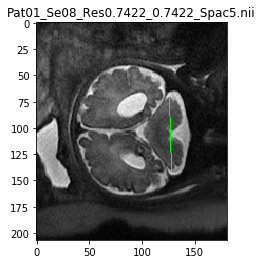

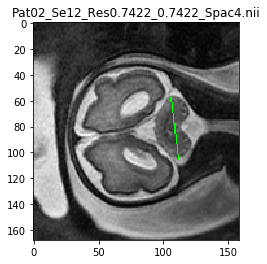

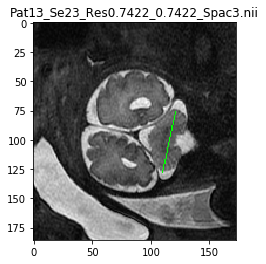

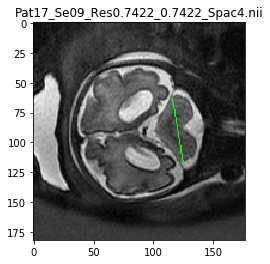

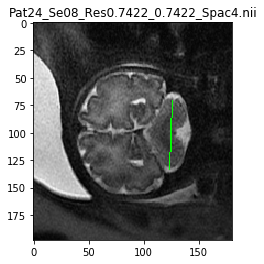

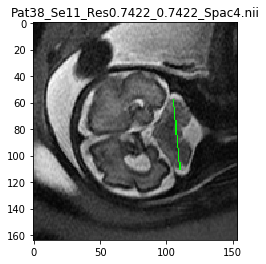

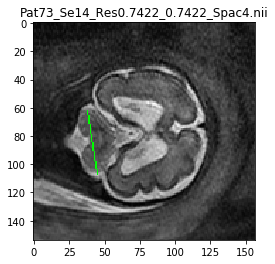

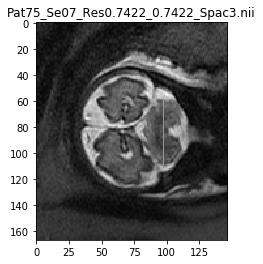

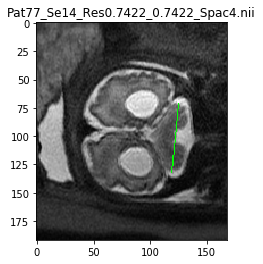

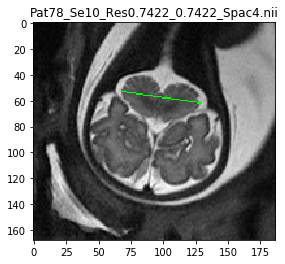

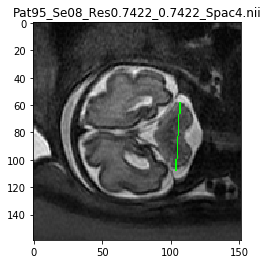

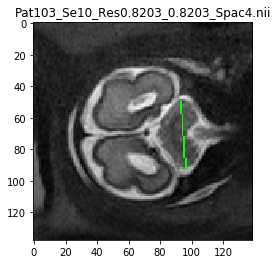

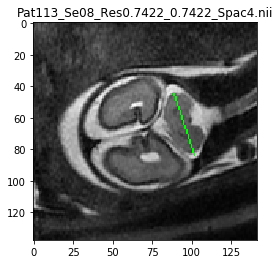

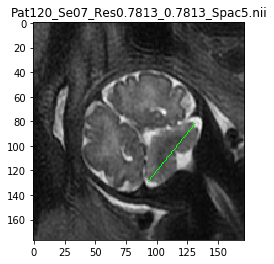

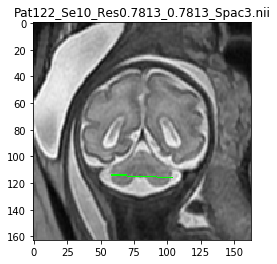

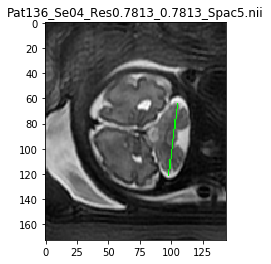

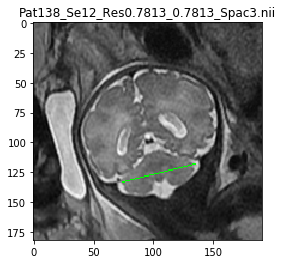

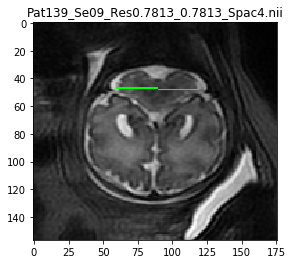

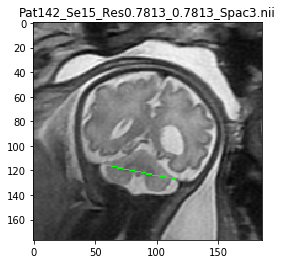

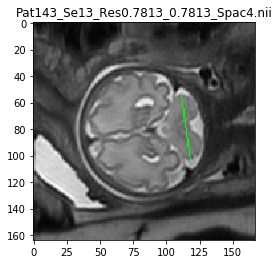

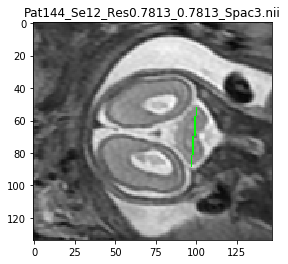

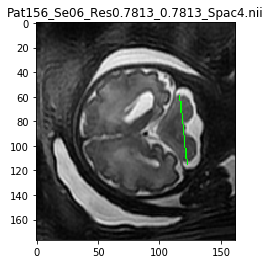

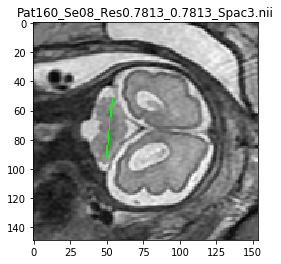

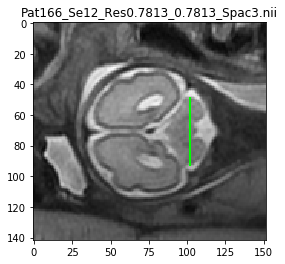

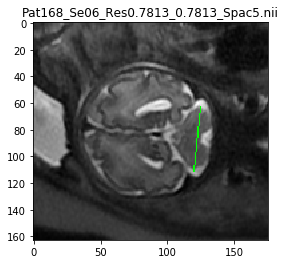

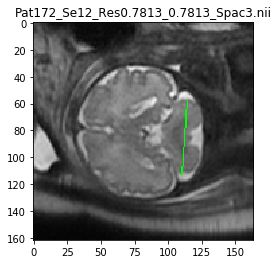

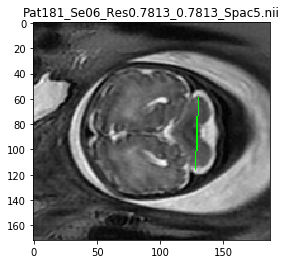

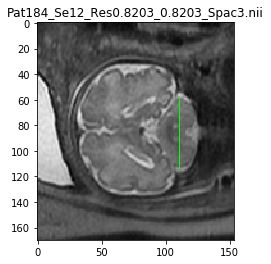

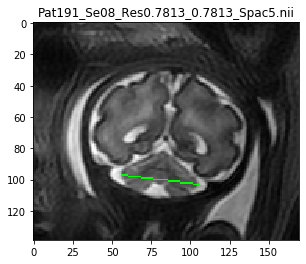

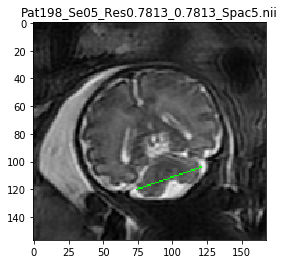

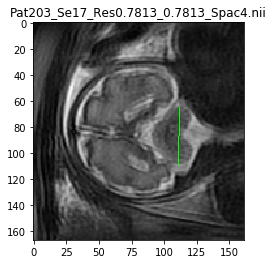

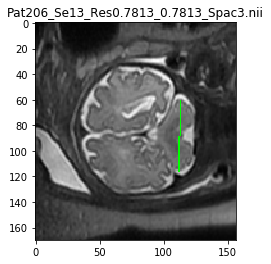

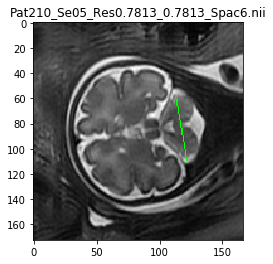

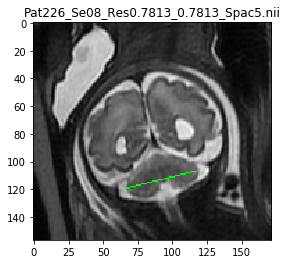

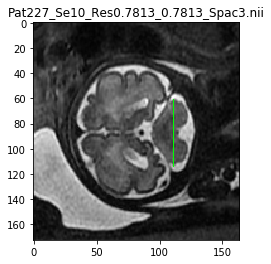

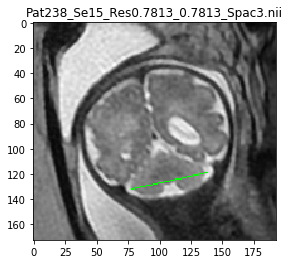

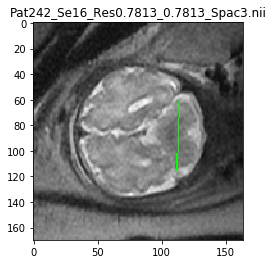

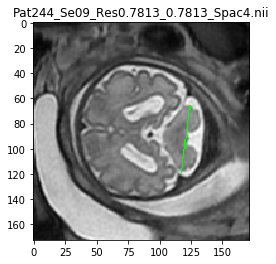

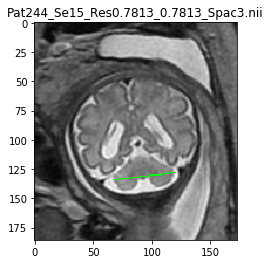

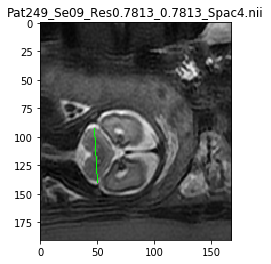

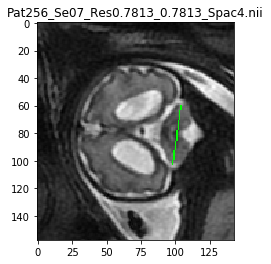

In [40]:
FETAL_DB_DIR = "/cs/casmip/netana03/data/"
OUTPUT_PNG_DIR = "/cs/casmip/netana03/work/trials/HRNet-Facial-Landmark-Detection/data/fetal/images"
for i, line in df_plus_shifts.iterrows():
    
    print (line['Filename'])
    plt.figure()
    img = nibabel.load(os.path.join(FETAL_DB_DIR, line['Filename'])).get_fdata()
    if np.isnan(line['TCD_Selection']):
        continue
    tcd_plane = img[:,:,int(line['TCD_Selection'] - 1)]
    #plt.imshow(tcd_plane)
    x1_point = int(line['Measure_TCD_X1'] - line['XStart'])
    y1_point = int(line['Measure_TCD_Y1'] - line['YStart'])
    x2_point = int(line['Measure_TCD_X2'] - line['XStart'])
    y2_point = int(line['Measure_TCD_Y2'] - line['YStart'])
    
    df_plus_shifts.loc[i, 'Measure_TCD_X1'] = x1_point
    df_plus_shifts.loc[i, 'Measure_TCD_X2'] = x2_point
    df_plus_shifts.loc[i, 'Measure_TCD_Y1'] = y1_point
    df_plus_shifts.loc[i, 'Measure_TCD_Y2'] = y2_point
    im2show = (tcd_plane / np.max(tcd_plane)).astype(np.float32)
    im2show = cv2.cvtColor(im2show, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(os.path.join(OUTPUT_PNG_DIR, line['Filename']+".png"), im2show*255.)
    im2show = cv2.line(im2show, (y1_point,x1_point), (y2_point, x2_point), (0,255,0), 1)
    plt.imshow(im2show)
    plt.title(line['Filename'])
    
    

In [22]:
df_plus_shifts.to_excel("/cs/casmip/netana03/data/Points_Liat2.xlsx")

In [19]:
#Create excel for HRNet
df_for_hrnet = pd.DataFrame(columns=["image_name","scale","center_w", "center_h", "tcd_1_x", "tcd_1_y","tcd_2_x", "tcd_2_y",])
for i, line in df_plus_shifts.iterrows():
    if np.isnan(line['TCD_Selection']):
        continue
    #assume generate to 64x64 life 300w?
    img_orig_fn = line['Filename'] + ".png"
    img_orig = cv2.imread(os.path.join(OUTPUT_PNG_DIR, img_orig_fn))
    h,w, _ = img_orig.shape
    c_x = w/2.
    c_y = h/2.
    scale = (max(w,h) / (1.7)) / 256.

    df_for_hrnet.loc[i] = [img_orig_fn, scale, c_x, c_y, line['Measure_TCD_X1'], line['Measure_TCD_Y1'], line['Measure_TCD_X2'], line['Measure_TCD_Y2']]


In [20]:
df_for_hrnet.to_csv("/cs/casmip/netana03/work/trials/HRNet-Facial-Landmark-Detection/data/fetal/test.csv")

In [ ]:
df_for